In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from collections import defaultdict, Counter

In [10]:
from torch.utils.data.sampler import *
from torch.utils.data import DataLoader

### `SequentialSampler`
same as `shuffle=False`

In [11]:
dset = range(10)
dl_train = DataLoader(dset, batch_size=2, sampler=SequentialSampler(dset))

for x in dl_train:
    print(x)

tensor([0, 1])
tensor([2, 3])
tensor([4, 5])
tensor([6, 7])
tensor([8, 9])


### `RandomSampler`
smae as `shuffle=True`

In [12]:
dset = range(10)
dl_train = DataLoader(dset, batch_size=2, sampler=RandomSampler(dset))

for x in dl_train:
    print(x)

tensor([6, 9])
tensor([5, 4])
tensor([1, 0])
tensor([2, 3])
tensor([7, 8])


### `SubsetRandomSampler`
Only sample even samples 

In [13]:
dset = range(20)
idx = torch.tensor(dset) % 2 == 0
dl_train = DataLoader(dset, batch_size=2, sampler=SubsetRandomSampler(np.where(idx)[0]))

for x in dl_train:
    print(x)

tensor([12,  6])
tensor([ 8, 18])
tensor([2, 4])
tensor([ 0, 10])
tensor([14, 16])


### `WeightedRandomSampler`

The weighted sampling should be used for training, to balance the classes in each batch, when there are unbalanced classes in the dataset.

First we create a custom dataset with unbalanced labels. This dataset has two classes: calss 0 has 10 samples and class 1 has 30 samples

In [79]:
class Dset(torch.utils.data.Dataset):
    def __init__(self):
        super(Dset, self).__init__()
        x = list(zip(np.arange(40), [0]*10 + [1]*30))
        np.random.shuffle(x)
        self.data = torch.tensor([y for (y, _) in x])
        self.targets = [y for (_, y) in x ]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i], self.targets[i]
    
dset = Dset()    

In [80]:
# a simple random sampler
dl = DataLoader(dset, batch_size=4, shuffle=True)
for x, y in dl:
    print(x, y)

tensor([30, 24, 21, 33]) tensor([1, 1, 1, 1])
tensor([19, 23, 32,  7]) tensor([1, 1, 1, 0])
tensor([39,  6, 37, 35]) tensor([1, 0, 1, 1])
tensor([ 1,  5,  2, 16]) tensor([0, 0, 0, 1])
tensor([11, 31, 10, 29]) tensor([1, 1, 1, 1])
tensor([20,  4,  9,  0]) tensor([1, 0, 0, 0])
tensor([22, 14, 28, 36]) tensor([1, 1, 1, 1])
tensor([ 3,  8, 12, 17]) tensor([0, 0, 1, 1])
tensor([13, 26, 18, 25]) tensor([1, 1, 1, 1])
tensor([15, 34, 38, 27]) tensor([1, 1, 1, 1])


We can see that the batches are not balanced, causing the training to overfit 

In [160]:
# Weighted random sampler
batch_size = 4
class_count = Counter([i_label for (_, i_label) in dset])


weight = {k: 1./v for k, v in class_count.items()}
sample_weight = [weight[i] for _, i in dset]

print(f'class count: {class_count}')
print(f'class weight: {weight}')

dl = DataLoader(dset, batch_size=batch_size,
                sampler=WeightedRandomSampler(sample_weight, len(dset), replacement=True))

for x, y in dl:
    print(x, y)


class count: Counter({1: 30, 0: 10})
class weight: {1: 0.03333333333333333, 0: 0.1}
tensor([ 9, 27, 17, 11]) tensor([0, 1, 1, 1])
tensor([ 9, 38,  7, 13]) tensor([0, 1, 0, 1])
tensor([ 4,  0,  9, 33]) tensor([0, 0, 0, 1])
tensor([6, 4, 8, 6]) tensor([0, 0, 0, 0])
tensor([25,  6, 20, 13]) tensor([1, 0, 1, 1])
tensor([33,  6,  5,  3]) tensor([1, 0, 0, 0])
tensor([ 2, 19, 13,  8]) tensor([0, 1, 1, 0])
tensor([ 0, 37,  0, 19]) tensor([0, 1, 0, 1])
tensor([ 3,  8, 23,  2]) tensor([0, 0, 1, 0])
tensor([21,  7, 16, 18]) tensor([1, 0, 1, 1])


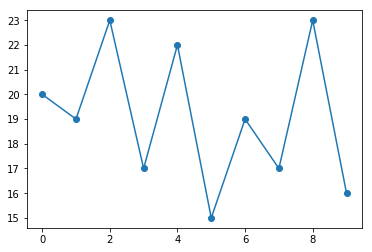

In [165]:
ys_sum = []
for i in range(10):
    ys = torch.tensor([], dtype=torch.long)
    for x, y in dl:
        ys = torch.cat([ys, y])

    ys_sum.append(torch.sum(ys))
plt.plot(ys_sum, '-o')